Creemos que la existencia de datos ambiguos en el training set es la causa fundamental de pérdida de calidad en los modelos predictivos para ciertos usuarios.

Para ver si realmente es así, haremos lo siguiente:

* Definiremos una medida de ambigüedad

* Veremos si esta se correlaciona con medidas de calidad de clasificación (precision, recall, Matthews correlation, AUROC, etc.)

*idea*: si el vector $x$ aparece en el set de entrenamiento $m$ veces con $y=0$ y $n$ veces con $y=1$, asumimos que un buen clasificador le asignará a $x$ el valor más frecuente de $y$.

Conjeturamos que en general los *falsos negativos* ( causa del bajo *recall* en la clase $1$ ) provienen de ambigüedades en el *training set*. Veamos si esto se cumple en los usuarios analizados, viendo si hay correlación entre ambas cantidades. 

In [1]:
from experiments._1_one_user_learn_neighbours.try_some_users import *
from experiments.utils import *
from experiments.datasets import *
import json

Switching to API Credentials #4


Calculamos para cada usuario su *recall* en el *train set* y su *máximo recall*. ( considerando el mínimo de falsos negativos causados por ambigüedad en los datos )

In [66]:
from sklearn.metrics import recall_score

In [ ]:
# recalls_train = {}
# recalls_amb = {}

# for uid, _, _ in TEST_USERS_ALL:
#     try:
#         clf = load_model(uid)
#     except Exception:
#         continue

#     X_train, X_test, y_train, y_test = load_or_create_dataframe(uid)

#     y_true, y_pred = y_train, clf.predict(X_train)
#     recalls_train[uid] = recall_score(y_true, y_pred)

#     miss_clf_counts, _ = count_doomed_samples(X_train, y_train)
#     min_false_neg = miss_clf_counts[1]
    
#     total_pos = sum(y_train)
#     max_recall = (total_pos - min_false_neg) * 1.0 / total_pos
#     recalls_amb[uid] = max_recall

In [112]:
with open('recalls_train.json', 'w') as f:
    json.dump(recalls_train, f)

with open('recalls_amb.json', 'w') as f:
    json.dump(recalls_amb, f)

In [68]:
with open('recalls_train.json') as f:
    recalls_train = json.load(f)

with open('recalls_amb.json') as f:
    recalls_amb = json.load(f)

In [115]:
len(recalls_train)

194

In [116]:
uids = recalls_train.keys()

recalls_train_vals = np.array([recalls_train[u] for u in uids])
recalls_amb_vals = np.array([recalls_amb[u] for u in uids])

In [117]:
from math import sqrt

def mse(a,b):
#     mean squared error
#     n = len(a)
    return sqrt(np.mean((a-b)**2))

def mae(a, b):
#     mean absolute error
#     n = len(a)
    return np.mean(np.abs(a-b))

def md(a,b):
#     mean difference
    return np.mean(a-b)

In [118]:
mse(recalls_train_vals, recalls_amb_vals)

0.07265089324804186

In [119]:
mae(recalls_amb_vals, recalls_train_vals)

0.024568726425359243

In [120]:
md(recalls_amb_vals, recalls_train_vals)

0.024568726425359243

Vemos que el *recall* de entrenamiento es en promedio un $2.5\%$ menor que  el máximo *recall* dado por las ambigüedades del *training set*.

In [121]:
np.max(recalls_amb_vals - recalls_train_vals)

0.87121212121212122

La mayor diferencia observada es $16\%$

Visualicemos ambas métricas:

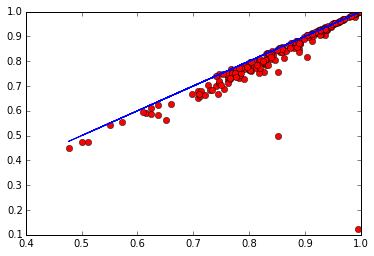

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_data = [
    recalls_amb_vals, recalls_train_vals, 'ro', # comparison
    recalls_amb_vals, recalls_amb_vals, '' # equality line
]
plt.plot(*plot_data)

In [12]:
from scipy.stats import pearsonr

In [123]:
pearsonr(recalls_amb_vals, recalls_train_vals)

(0.84413531189138724, 7.1171031248442482e-54)

In [124]:
np.argmin(recalls_train_vals)

142

In [125]:
recalls_train.items()[142]

(u'241991145', 0.12373737373737374)

# Caso muuuuy malo

El punto rojo de abajo a la derecha es un *outlier* muy marcado. Investiguemos por qué da tan malos resultados.

In [16]:
import numpy as np

In [17]:
np.median(recalls_train_vals)

0.83009708737864074

In [18]:
recalls_train_vals[117]

0.83918128654970758

In [19]:
recalls_train.keys()[117]

u'188525384'

In [20]:
uid = 241991145

In [21]:
clf = load_model(uid)

In [22]:
X_train, X_test, y_train, y_test = load_or_create_dataframe(uid)

In [23]:
evaluate_model(clf, X_train, X_test, y_train, y_test)

Detailed classification report:

Scores on training set.

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    159988
        1.0       0.91      0.12      0.22       396

avg / total       1.00      1.00      1.00    160384

Scores on test set.

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     68533
        1.0       0.69      0.10      0.17       203

avg / total       1.00      1.00      1.00     68736



In [24]:
miss_clf_counts, details = count_doomed_samples(X_train, y_train)

In [25]:
details

[([u"Luis D'Elia"], {0.0: 259, 1.0: 335}),
 ([u"Luis D'Elia", u'Leonardo Cofr\xe9'], {0.0: 7, 1.0: 1}),
 ([u"Luis D'Elia", u'Juan M. Rapacioli'], {0.0: 1, 1.0: 2}),
 ([u'Horacio Roggero', u"Luis D'Elia"], {0.0: 1, 1.0: 1}),
 ([u'Fernando Esteche'], {0.0: 233, 1.0: 1}),
 ([u'Araceli Ferreyra', u"Luis D'Elia"], {0.0: 1, 1.0: 1}),
 ([u'Hamartia', u"Luis D'Elia"], {0.0: 1, 1.0: 1}),
 ([u'Marcel #RadioRetro', u"Luis D'Elia"], {0.0: 1, 1.0: 1}),
 ([u'Luisa Hynes', u"Luis D'Elia"], {0.0: 1, 1.0: 6})]

In [26]:
s=open_session()


In [27]:
user=s.query(User).get(uid)

In [28]:
user.username

u'Partido MILES'

Veamos si agregar usuarios que desambigüen mejora la situación

In [29]:
neighbours = get_neighbourhood(uid)
error_sources = details

unames = [x[0][0] for x in error_sources]
amb_users = {u.username: u for u in neighbours if u.username in unames}
amb_ids = {u.id for u in amb_users.values()}

# tweets con un solo 1 en todo X_train y con 1 en y_train
cands = X_train[(y_train == 1) & (X_train.sum(axis=1) == 1)]

# y ese en alguno de los amb_users
amb_tweets = []
for twid in cands.index:
    t = s.query(Tweet).get(twid)
    if t.author_id in amb_ids:
        amb_tweets.append(t)

In [30]:
len(amb_tweets)

321

In [31]:
amb_rt_counts = defaultdict(int)
neighbour_ids = [n.id for n in neighbours]
for t in amb_tweets:
    for u in t.users_retweeted:
        if u.id not in (neighbour_ids + [user.id]):
            amb_rt_counts[u.id] += 1
    if t.author_id not in (neighbour_ids + [user.id]):
        amb_rt_counts[t.author_id] += 1
    
new_neighbours = sorted(amb_rt_counts.items(), key=lambda x: -x[1])
new_neighbour_ids = [x[0] for x in new_neighbours]
new_neighbours = [s.query(User).get(uid) for uid in new_neighbour_ids]

In [32]:
len(new_neighbours)

32

In [33]:
tweet_ids = X_train.index
tweets = [s.query(Tweet).get(twid) for twid in tweet_ids]

X_train_new, _ = extract_features(tweets, new_neighbours, user)

X_train_new = pd.DataFrame(data=X_train_new, index=tweet_ids, columns=new_neighbour_ids)

X_train_extended = pd.concat([X_train,X_train_new],axis=1)

In [34]:
# weights for class balancing
w1 = sum(y_train)/len(y_train)
w0 = 1 - w1
sample_weights = np.array([w0 if x==0 else w1 for x in y_train])

clf = RandomForestClassifier()     
clf.fit(X_train_extended, y_train, sample_weight=sample_weights)

y_true, y_pred = y_train, clf.predict(X_train_extended)

print("Scores on training set.\n")
print(classification_report(y_true, y_pred))

Scores on training set.

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    159988
        1.0       0.96      0.23      0.37       396

avg / total       1.00      1.00      1.00    160384



In [35]:
miss_clf_counts, details = count_doomed_samples(X_train_extended, y_train)

In [36]:
details

[([u"Luis D'Elia"], {0.0: 247, 1.0: 282}),
 ([u"Luis D'Elia", u'MILES'], {0.0: 2, 1.0: 7}),
 ([u"Luis D'Elia", u'MILES', u'RUBEN KANUELAS'], {0.0: 2, 1.0: 7}),
 ([u"Luis D'Elia", u'@lauritalonso'], {0.0: 1, 1.0: 1}),
 ([u"Luis D'Elia", u'AlfredoLeuco'], {0.0: 1, 1.0: 3}),
 ([u"Luis D'Elia", u'Gustavo Leonardo'], {0.0: 1, 1.0: 3}),
 ([u"Luis D'Elia", u'Leonardo Cofr\xe9'], {0.0: 7, 1.0: 1}),
 ([u"Luis D'Elia", u'Juan M. Rapacioli'], {0.0: 1, 1.0: 2}),
 ([u'Horacio Roggero', u"Luis D'Elia"], {0.0: 1, 1.0: 1}),
 ([u'Fernando Esteche'], {0.0: 233, 1.0: 1}),
 ([u'Araceli Ferreyra', u"Luis D'Elia"], {0.0: 1, 1.0: 1}),
 ([u'Hamartia', u"Luis D'Elia"], {0.0: 1, 1.0: 1}),
 ([u'Marcel #RadioRetro', u"Luis D'Elia"], {0.0: 1, 1.0: 1}),
 ([u'Luisa Hynes', u"Luis D'Elia"], {0.0: 1, 1.0: 4})]

Veamos cómo se está clasificando la principal clase ambigua

In [37]:
ld = [n for n in neighbours if n.username=="Luis D'Elia"][0]

In [38]:
ld.id

132704571

In [39]:
X_ld = X_train_extended[X_train_extended[132704571] == 1]

In [40]:
X_ld.shape

(697, 744)

In [41]:
y_ld = clf.predict(X_ld)

In [42]:
sum(y_ld)

80.0

# Análisis de desambiguación de datos

Estudiaremos la mejora introducida por desambiguar datos con usuarios que retweetean tuits ambiguos. Hacemos esto sólo para los casos en los que la recall es menor al 90%.

In [43]:
lowr_uids = [uid for uid, recall in recalls_train.items() if recall < 0.9]

In [44]:
len(lowr_uids)

135

In [45]:
# Recalls calculados en paralelo en disambiguation_analysis.py
# ( agregar 3 usuarios faltantes )

In [46]:
import json
with open('recalls_train.json') as f:
    recalls_train = json.load(f)

with open('recalls_amb.json') as f:
    recalls_amb = json.load(f)

with open('recalls_train_disamb.json') as f:
    recalls_train_disamb = json.load(f)

with open('recalls_test_disamb.json') as f:
	recalls_test_disamb = json.load(f)

with open('recalls_test_amb.json') as f:
    recalls_test_amb = json.load(f)


In [47]:
import numpy as np

In [48]:
_recalls_train = {uid: r for (uid, r) in recalls_train.items() if uid in lowr_uids}
np.mean(_recalls_train.values())

0.73701274369941683

In [49]:
np.mean(recalls_amb.values())

0.84243272361767041

In [50]:
np.mean(recalls_train_disamb.values())

0.7683766814605606

In [51]:
np.mean(recalls_test_amb.values())

0.68244042665626681

In [52]:
np.mean(recalls_test_disamb.values())

0.68101238124473629

In [53]:
recalls_amb_vals = [recalls_amb[uid] for uid in lowr_uids]
recalls_test_amb_vals = [recalls_test_amb[uid] for uid in lowr_uids]
recalls_test_disamb_vals = [recalls_test_disamb[uid] for uid in lowr_uids]

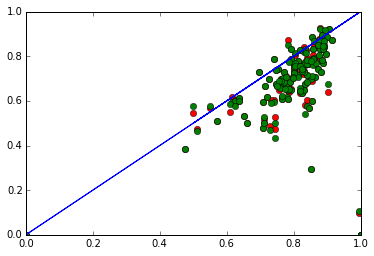

In [54]:
plot_data = [
    recalls_amb_vals, recalls_test_amb_vals, 'ro', # comparison
    recalls_amb_vals, recalls_test_disamb_vals, 'go', # comparison
    recalls_amb_vals, recalls_amb_vals, '' # equality line
]
plt.plot(*plot_data)